stock price prediction with Twitter sentiment data and Neural Network LSTM

We try to estimate index price movements using Nifty50 index data, Twitter sentiment analysis and Neural Network LSTM. We have nearly 65 000 tweets from 01/01/2015 to 31/12/2019 and daily Nifty index prices   

Finance is highly non-linear and non-stationary. Traditional time-series methods (ARIMA, SARIMAX) are only effective for stationary data. However, when modifying financial data stationaty (log-return etc) we typically lose information. Neural networks don't require any stationarity. 


part 1: Twitter sentiment analysis

part 2: LSTM with Nifty50 index data and Twitter sentiments. 


In [1]:
!pip install vaderSentiment
!pip install tensorflow
!pip install wordcloud

In [2]:
import pandas as pd
from urllib.request import Request, urlopen
from bs4 import BeautifulSoup as soup
import random
import re
from tqdm import tqdm
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import date
import numpy as np

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
#from sklearn.metrics import mean_squared_error
#from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

from tensorflow.keras import backend as K

2024-03-26 16:59:52.418350: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Part 1: Twitter sentiment analysis

1. We download the Twitter data 

In [15]:
ndtv1 = pd.read_csv('NDTVProfit_2015-1-1_2016-5-1.csv')
ndtv2 = pd.read_csv('NDTVProfit_2016-5-1_2016-8-1.csv')
ndtv3 = pd.read_csv('NDTVProfit_2016-8-1_2017-1-1.csv')
ndtv4 = pd.read_csv('NDTVProfit_2017-1-1_2018-1-1.csv')
ndtv5 = pd.read_csv('NDTVProfit_2018-1-1_2019-1-1.csv')
ndtv6 = pd.read_csv('NDTVProfit_2019-1-1_2020-1-1.csv')

tweet_news = pd.concat([ndtv1, ndtv2, ndtv3, ndtv4, ndtv5, ndtv6])

In [16]:
tweet_news.head()

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,...,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,726427098294820864,726427098294820864,2016-04-30 20:34:51 IST,2016-04-30,20:34:51,530,420943164,ndtvprofit,NDTV Profit,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
1,726425574508371968,726425574508371968,2016-04-30 20:28:47 IST,2016-04-30,20:28:47,530,420943164,ndtvprofit,NDTV Profit,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
2,726418832466677760,726418832466677760,2016-04-30 20:02:00 IST,2016-04-30,20:02:00,530,420943164,ndtvprofit,NDTV Profit,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
3,726417904535621633,726417904535621633,2016-04-30 19:58:19 IST,2016-04-30,19:58:19,530,420943164,ndtvprofit,NDTV Profit,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
4,726416261383512066,726416261383512066,2016-04-30 19:51:47 IST,2016-04-30,19:51:47,530,420943164,ndtvprofit,NDTV Profit,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN


In [17]:
tweet_news.shape

(66892, 36)

We start by cleaning tweets. Each tweet contains a lot of meta information, we keep only the date and the tweet. 

Remove extra columns from the dataframe 'tweet_news' and save only the columns 'date' and 'tweet'. 
Sort the tweet according to the date in decending order.

In [18]:
# Removing extra columns
tweet_news = tweet_news[['date', 'tweet']]

Drop all duplicates. (df.drop_duplicates)

In [19]:

# Sorting tweets by date in descending order
tweet_news = tweet_news.sort_values(by='date', ascending=False)

# Dropping duplicate values
tweet_news = tweet_news.drop_duplicates(keep=False)


# Reset index after dropping duplicates
tweet_news.reset_index(drop=True, inplace=True)

In [20]:
#tweet_news.to_csv('news.csv', index = False)

In [21]:
tweet_news.shape

#should be (66866, 2)

(66866, 2)

2. Data Cleaning and Pre-processing

Let's print out 25 random tweets to analyze better. You can use 'random.sample'

In [22]:
#Let's print out 25 random tweets to analyze better.

randomlist = random.sample(range(0, len(tweet_news)),25)

for i in tweet_news.itertuples():
     if i[0] in randomlist:
        print(f"Tweet No. {i[0]}: {i[2]}")
     else:
        pass

Tweet No. 167: Workers At State-Run Firms Oppose Privatisation Of Bharat Petroleum  https://t.co/njBZaY0LHX
Tweet No. 901: India Inc Welcomes Government's Corporate Tax Announcements  https://t.co/dE3ndUVnnO
Tweet No. 6019: Sensex Drops 174 Points, Nifty Settles At 10,301  https://t.co/1exAih1BxH
Tweet No. 7848: Sensex edges lower, Nifty holds 10,650; Vedanta shares fall 4%
Tweet No. 8579: Vodafone SuperPlans: Rs 255 Vs Rs 348 Vs Rs 349 Vs Rs 458 Vs Rs 799 And More   https://t.co/goTfBR0aCA
Tweet No. 10298: World To Be Riskier Place In 2018: WEF Survey  https://t.co/H76459Azmp
Tweet No. 12064: Bharat Financial Shares Gain Over 4%; IndusInd Bank Slips  https://t.co/XKTo0gu5EL
Tweet No. 13131: Raise Funds Through Equity, Not Debt: SBI Chief Tells SMEs  https://t.co/RQg0dB01sQ  https://t.co/Xsowmmd4GM
Tweet No. 15224: GST Clinics To Help Traders In Smooth Transition  https://t.co/CDYKMLi9WS
Tweet No. 16807: Jet Airways Offers One-Day 24% Discount In Mega Fare Sale  https://t.co/tL5rNn8b9q

Next, we clean the tweets. Fill the places indicated below. 

In [23]:
#Cleaning the tweets

def decontracted(phrase):
    ## specific
    phrase = re.sub(r"won't", "will not", phrase)
      # below,replace "can\'t" with "can not", similarly to "won't" -> "will not"
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    ## general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase) 
      # below,replace "\'t" with " not"; "\'ve" with " have" and "\'m" with " am"
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def clean(text):
    text = str(text)
        # change the string (text) to lower case. 
    text = text.lower()
    text = re.sub(r'http\S+', ' ', text)
    text = re.sub(r'pic.twitter\S+', ' ', text)
    text = decontracted(text)
    text = re.sub(r'\(([^)]+)\)', " ", text)
    text = text.replace('etmarkets', ' ').replace('marketupdates', ' ').replace('newsalert', ' ').replace('ndtv', ' ').replace('moneycontrol', ' ').replace('here is why', ' ')
    text = text.replace('marketsupdate', ' ').replace('biznews', ' ').replace('click here', ' ').replace('live updates', ' ').replace('et now', ' ')
    text = re.sub(r'[^a-zA-Z ]+', ' ', text)
    text = re.sub(r' \w{1,2}_', ' ', text)
    text = re.sub('\s+',' ', text)
    return text

In [24]:
for i in tqdm(tweet_news.itertuples()):
    tweet_news.at[i[0], 'tweet_processed'] = clean(i[2])

66866it [00:02, 32675.47it/s]


That's all we will be doing with our news dataset. We do not need to tokenize, remove stopwords, and get bigrams, etc because we will be using a pre-trained sentiment analyzer VADER here since our data is unsupervised.
We are choosing VADER here because it works very well with social media text especially.

We combine all the tweets posted on a single date.

In [25]:
#Combining all the tweets posted on a single date
tweet_news['tweet_news_combined'] = tweet_news.groupby(['date'])['tweet_processed'].transform(lambda x: ' '.join(x))

tweet_news.head()

,date,tweet,tweet_processed,tweet_news_combined
0,2019-12-31,"Sensex, Nifty Likely To Open Lower On Last Ses...",sensex nifty likely to open lower on last sess...,sensex nifty likely to open lower on last sess...
1,2019-12-31,Finance Minister Nirmala Sitharaman announces ...,finance minister nirmala sitharaman announces ...,sensex nifty likely to open lower on last sess...
2,2019-12-31,"Sensex falls over 100 points, Nifty drops belo...",sensex falls over points nifty drops below tec...,sensex nifty likely to open lower on last sess...
3,2019-12-31,Last Date To Link PAN With Aadhaar Extended Fo...,last date to link pan with aadhaar extended fo...,sensex nifty likely to open lower on last sess...
4,2019-12-31,"In four months, task force held 70 consultatio...",in four months task force held consultations w...,sensex nifty likely to open lower on last sess...


Define a dataframe 'tweet_news' consisting of 2 columns, 'date' and 'tweet_news_combined'.

Drop duplicates and sort the values by 'date'.

In [30]:
# Define a dataframe 'tweet_news' consisting of 2 columns, 'date' and 'tweet_news_combined'
tweet_news = tweet_news[['date', 'tweet_news_combined']].drop_duplicates()

# Sort the values by 'date'
tweet_news = tweet_news.sort_values(by='date')

# Display the first few rows of the dataframe
tweet_news.head()

,date,tweet_news_combined
66830,2015-01-01,consolidation of psu banks to be key theme at ...
66785,2015-01-02,market update nifty regains mark rises with ba...
66750,2015-01-03,banks need greater autonomy finance minister a...
66734,2015-01-04,coal india likely to hire executives in months...
66682,2015-01-05,ashok leyland sales jump in december max indi...


In [31]:
tweet_news.shape

# this should be (1820,2)

(1820, 2)

In [32]:
tweet_news.reset_index(drop = True)
tweet_news.to_csv('news_processed.csv', index =False)

3. Feature Engineering

We analyze all the tweet news data to predict sentiments using VADER Library.

In [33]:
tweet_news = pd.read_csv('news_processed.csv')

In [34]:
tweet_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1820 entries, 0 to 1819
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   date                 1820 non-null   object
 1   tweet_news_combined  1820 non-null   object
dtypes: object(2)
memory usage: 28.6+ KB


In [35]:
#We add some new words to Vader Dictionary to judge stock market news better.

new_words =  {'falls': -9, 'drops': -9, 'rise': 9, 'increases': 9, 'gain': 9, 'hiked': -9, 'dips': -9, 'declines': -9, 'decline': -9, 'hikes': -9, 'jumps': 9,
              'lose': -9, 'profit': 9, 'loss': -9, 'shreds': -9, 'sell': -9, 'buy': 9, 'recession': -9, 'rupee weakens': -9, 'record low': -9, 'record high': 9,
              'sensex up': 9, 'nifty down': -9, 'sensex down': -9, 'nifty up': 9} 

analyser = SentimentIntensityAnalyzer()
analyser.lexicon.update(new_words)



In [36]:
for i in tqdm(tweet_news.itertuples()):
    score = analyser.polarity_scores(tweet_news.iloc[i[0]]['tweet_news_combined'])

    tweet_news.at[i[0], 'score'] = score['compound']

    if score['compound'] >= 0:
        tweet_news.at[i[0], 'sentiment'] = 1
    else:
        tweet_news.at[i[0], 'sentiment'] = -1

1820it [00:18, 97.29it/s] 


In [38]:
tweet_news.head()

,date,tweet_news_combined,score,sentiment
0,2015-01-01,consolidation of psu banks to be key theme at ...,0.9805,1.0
1,2015-01-02,market update nifty regains mark rises with ba...,0.9981,1.0
2,2015-01-03,banks need greater autonomy finance minister a...,0.9459,1.0
3,2015-01-04,coal india likely to hire executives in months...,0.9648,1.0
4,2015-01-05,ashok leyland sales jump in december max indi...,0.9935,1.0


In [39]:
tweet_news_original = tweet_news.copy() # we will need the original data later

In [40]:
tweet_news.to_csv('news_combined_with_sentiments.csv', index =False)

In [41]:
tweet_news[['date', 'sentiment']].to_csv('sentiments_final.csv', index =False)

Use countplot to present the count on sentiment variables

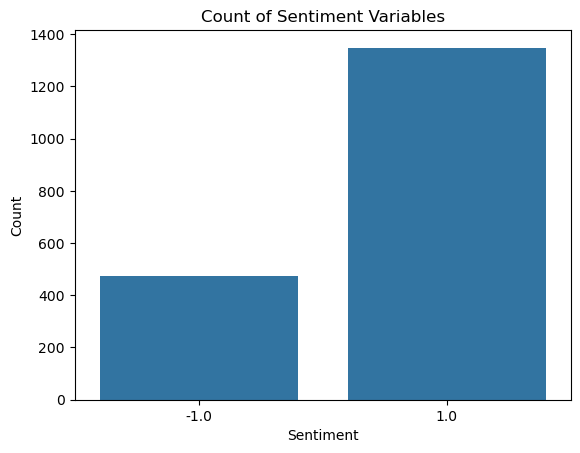

In [42]:
# plot here
sns.countplot(x='sentiment', data=tweet_news)
plt.title('Count of Sentiment Variables')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [43]:
tweet_news['sentiment'].value_counts()

sentiment
 1.0    1348
-1.0     472
Name: count, dtype: int64

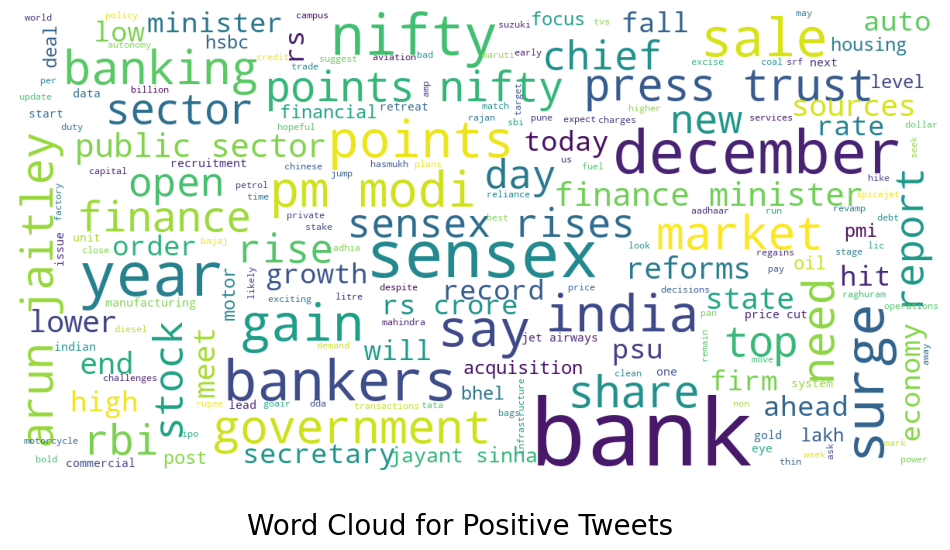

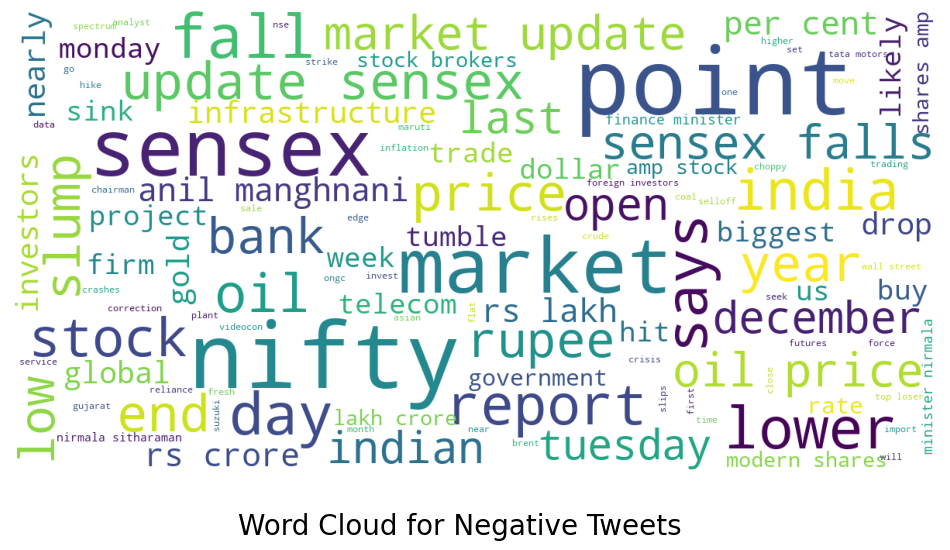

In [44]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200000,
        max_font_size=40, 
        scale=3,
        random_state=1).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(tweet_news[tweet_news['sentiment'] == 1].values, title="Word Cloud for Positive Tweets")

show_wordcloud(tweet_news[tweet_news['sentiment'] == -1].values, title="Word Cloud for Negative Tweets")

Probability Distribution of Sentiment Scores by VADER. Plot the probability distribution of the tweet_news column score. 
Q: What can you say about the confidence of VADER in detecting either positive or negative sentiments?

since there's a more concentrated distribution around extreme values may indicate higher confidence. however the data is unbalanced so we might not trust it as much

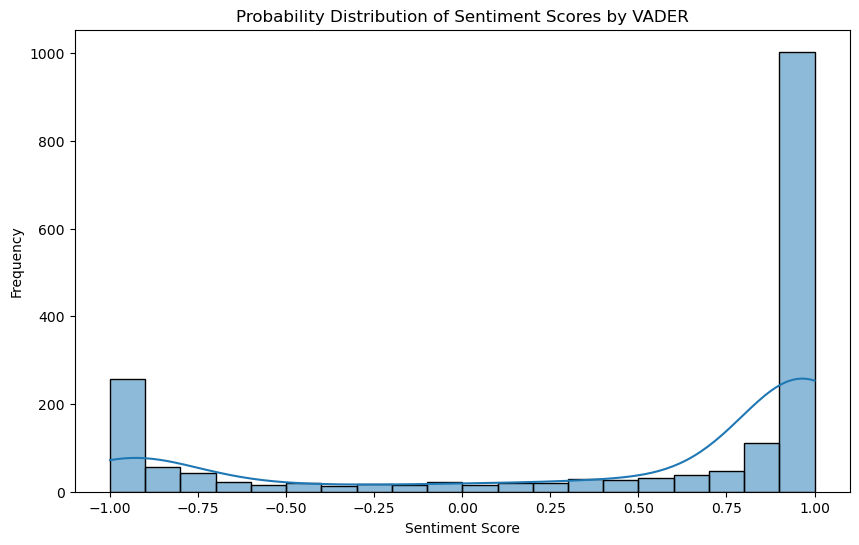

In [45]:
# plot the probability distribution here, you can use sns.histplot
plt.figure(figsize=(10, 6))
sns.histplot(data=tweet_news, x='score', kde=True, bins=20)
plt.title('Probability Distribution of Sentiment Scores by VADER')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()


Part 2: Long_short Term Memory LSTM  with news polarity

In [46]:
#Defining our metric
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

## 1. Prepare the data

Download the index price data'nifty_5yrs.csv' in the dataframe 'nifty'

In [47]:
nifty = pd.read_csv('nifty_5yrs.csv')
nifty.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1233 entries, 0 to 1232
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  1233 non-null   int64  
 1   date        1233 non-null   object 
 2   price       1233 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 29.0+ KB


Based on a concise summary of nifty, we change the data column in proper format. 

In [48]:
nifty['date'] = pd.to_datetime(nifty.date)
nifty.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1233 entries, 0 to 1232
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  1233 non-null   int64         
 1   date        1233 non-null   datetime64[ns]
 2   price       1233 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 29.0 KB


Now, we have in dtypes: datetime64

In [49]:
nifty.head()

,Unnamed: 0,date,price
0,0,2015-01-01,8284.00
1,1,2015-01-02,8395.45
2,2,2015-01-05,8378.40
3,3,2015-01-06,8127.35
4,4,2015-01-07,8102.10


In [50]:
tweet_news = tweet_news_original.copy()

In [51]:
tweet_news.reset_index(inplace = True)
tweet_news.set_index('date', inplace = True, drop = False)

tweet_news.info()

In [53]:
nifty.shape

(1233, 3)

In [54]:
tweet_news.shape

(1820, 5)

In [55]:

s = set([str(i).split('T')[0] for i in nifty['date'].values])
n = set(list(tweet_news['date'].values))

common_dates_1 = list(n.symmetric_difference(s))

for i in tweet_news.itertuples():
    if i[1] not in [str(i).split('T')[0] for i in nifty['date'].values]:
        tweet_news.drop(tweet_news[tweet_news['date'] == i[1]].index, inplace = True)
    else:
        pass

for j in common_dates_1:
    tweet_news.drop(tweet_news[tweet_news['date'] == j].index, inplace = True)
    nifty.drop(nifty[nifty['date'] == j].index, inplace = True)


Explain what was done in the cell above.

it's done to synchronize the dates between two datasets, nifty and tweet_news, by filtering out the dates that are not common between them.

In [56]:
tweet_news.shape


(1233, 5)

In [57]:
nifty.shape

(1233, 3)

In [58]:
tweet_news['date'] = tweet_news['date'].astype(str)
nifty['date'] = nifty['date'].astype(str)

In [59]:
tweet_news = tweet_news.drop('date', axis = 1)

In [60]:
data1 = pd.merge(tweet_news, nifty, on = 'date')

In [61]:
data1.head()

,date,index,tweet_news_combined,score,sentiment,Unnamed: 0,price
0,2015-01-01,0,consolidation of psu banks to be key theme at ...,0.9805,1.0,0,8284.00
1,2015-01-02,1,market update nifty regains mark rises with ba...,0.9981,1.0,1,8395.45
2,2015-01-05,4,ashok leyland sales jump in december max indi...,0.9935,1.0,2,8378.40
3,2015-01-06,5,sensex heading for biggest day fall since rupe...,-0.9982,-1.0,3,8127.35
4,2015-01-07,6,sensex correction nearly over says andrew holl...,-0.9930,-1.0,4,8102.10


In [62]:
data = data1[['date', 'score', 'price']]

## 2. Train and test sets

We split the 5 years stock data in Train-CV-Test in the ratio 64:16:20
First split data into train_data and test_data in the ratio 80:20
Then, split train_data to X_train and X_cv in the ratio 80:20

In [89]:
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False, random_state=42)
X_train, X_cv = train_test_split(train_data, test_size=0.2, shuffle=False, random_state=42)


In [90]:
X_train = X_train.set_index('date', drop= False)
X_cv = X_cv.set_index('date', drop= False)
test_data = test_data.set_index('date', drop= False)

In [91]:
len(X_train), len(X_cv), len(test_data)

(788, 198, 247)

In [92]:
def create_dataset(dataset, scoreset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		b = scoreset[i+look_back-1]
		dataX.append(np.append(a,b))
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [93]:
# Feature Scaling
sc = MinMaxScaler()
training_set_scaled = sc.fit_transform(X_train['price'].values.reshape(-1, 1))
cv_set_scaled = sc.transform(X_cv['price'].values.reshape(-1, 1))
test_set_scaled = sc.transform(test_data['price'].values.reshape(-1, 1))

sc1 = MinMaxScaler()
training_score_scaled = sc1.fit_transform(X_train['score'].values.reshape(-1, 1))
cv_score_scaled = sc1.transform(X_cv['score'].values.reshape(-1, 1))
test_score_scaled = sc1.transform(test_data['score'].values.reshape(-1, 1))

In [94]:

trainX, trainY = create_dataset(training_set_scaled, training_score_scaled, 60)
cvX, cvY = create_dataset(cv_set_scaled, cv_score_scaled, 60)
testX, testY = create_dataset(test_set_scaled, test_score_scaled, 60)


In [95]:
trainX.shape, cvX.shape, testX.shape

((727, 61), (137, 61), (186, 61))

Explain lightly what was done in the previous cells. What information are we using to predict the stock price for next day?

create_dataset to prepare the dataset for the prediction task. This function creates input features (dataX) and target labels (dataY) by iterating through the dataset and combining the historical stock prices with the corresponding sentiment scores.

We used MinMaxScaler to scale the stock prices (price) and sentiment scores (score) to a range between 0 and 1. 
We created the training, cross-validation (CV), and test datasets by applying the create_dataset function to the scaled stock prices and sentiment scores. We used a look-back window of 60 days, meaning that each sample in the dataset contains the stock prices and sentiment scores of the previous 60 days.
We verified the shapes of the created datasets to ensure that they have the correct dimensions for training and testing the model.
We use the sentiment score to predict the price.

In [96]:
#Reshaping all data.

trainX, trainY = np.array(trainX), np.array(trainY)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))

cvX, cvY = np.array(cvX), np.array(cvY)
cvX = np.reshape(cvX, (cvX.shape[0], cvX.shape[1], 1))

testX, testY = np.array(testX), np.array(testY)
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

## 3. LSTM

In [97]:
import tensorflow as tf 
from tensorflow import keras
from keras.callbacks import TensorBoard

!rm -rf ./logs/
keras.backend.clear_session()
%load_ext tensorboard

model = Sequential()

# Adding the input layer
model.add(LSTM(units=128, activation='tanh', kernel_initializer=tf.keras.initializers.glorot_uniform(seed=26), input_shape = (trainX.shape[1], 1), unroll = True))

# Adding the output layer
model.add(Dense(1, name="output_layer"))

# Compiling the RNN
model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.01), loss = root_mean_squared_error)

#Using Tensorboard
logdir = "logs"
tensorboard_callback = TensorBoard(log_dir=logdir, histogram_freq=5, write_graph=True)

# Fitting the RNN to the Training set
model.fit(trainX, trainY, epochs = 30, batch_size = 64,  validation_data =(cvX, cvY), callbacks = [tensorboard_callback])

rm: cannot remove './logs/train': Directory not empty
rm: cannot remove './logs/validation': Directory not empty
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Epoch 1/30
12/12 [==============================] - 8s 209ms/step - loss: 0.2217 - val_loss: 0.1520
Epoch 2/30
12/12 [==============================] - 1s 126ms/step - loss: 0.0685 - val_loss: 0.0446
Epoch 3/30
12/12 [==============================] - 1s 124ms/step - loss: 0.0502 - val_loss: 0.0907
Epoch 4/30
12/12 [==============================] - 1s 111ms/step - loss: 0.0364 - val_loss: 0.0492
Epoch 5/30
12/12 [==============================] - 1s 104ms/step - loss: 0.0309 - val_loss: 0.0428
Epoch 6/30
12/12 [==============================] - 1s 110ms/step - loss: 0.0264 - val_loss: 0.0439
Epoch 7/30
12/12 [==============================] - 1s 102ms/step - loss: 0.0251 - val_loss: 0.0296
Epoch 8/30
12/12 [==============================] - 1s 100ms/step - loss: 0.0245 - val_loss: 0.02

In [98]:
%tensorboard --logdir logs/

Reusing TensorBoard on port 6006 (pid 3053), started 2:17:22 ago. (Use '!kill 3053' to kill it.)

In [99]:
#Predicting on test data
predicted_stock_price = model.predict(testX)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

6/6 [==============================] - 1s 19ms/step


In [100]:
#Changing datatype of date column from string to datetime

train_data['date'] = pd.to_datetime(train_data['date'])
test_data['date'] = pd.to_datetime(test_data['date'])

train_data['date'] = train_data['date'].dt.date
test_data['date'] = test_data['date'].dt.date

Plot the train data price , test data price and predicted_stock_price as a function of time (date)

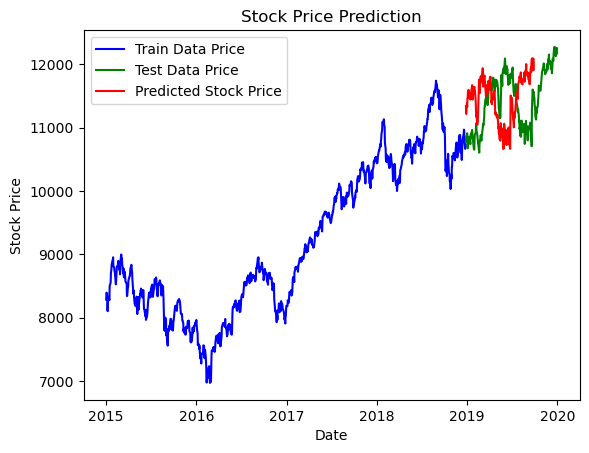

In [101]:
# Visualising the results
# Plotting train data price
plt.plot(train_data['date'], train_data['price'], color = 'blue', label = 'Train Data Price')

# Plotting test data price
plt.plot(test_data['date'], test_data['price'], color = 'green', label = 'Test Data Price')

date_slice = test_data['date'].iloc[:len(predicted_stock_price)]

# Plotting predicted stock price with sliced date array
plt.plot(date_slice, predicted_stock_price, color='red', label='Predicted Stock Price')

# Adding labels and title
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


This Model takes stock price data of last 60 days along with News Sentiment Compound Score from VADER for the last day and it will predict the stock price for next day.

Draw a similar plot with test data and predicted stock price. 

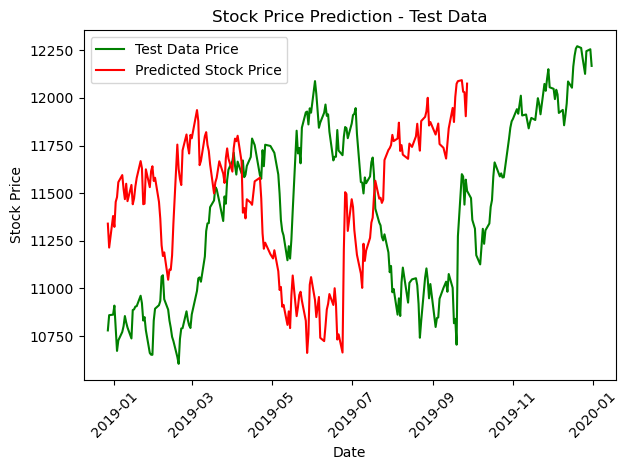

In [102]:
# Visualising the results
# Plotting test data price
plt.plot(test_data['date'], test_data['price'], color='green', label='Test Data Price')

# Plotting predicted stock price
plt.plot(test_data['date'].iloc[:len(predicted_stock_price)], predicted_stock_price, color='red', label='Predicted Stock Price')

# Adding labels and title
plt.title('Stock Price Prediction - Test Data')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()